# Análise Exploratória: Carga de Energia

Este notebook realiza uma análise exploratória dos dados de carga de energia. Ele cobre:
1. Carregamento e limpeza dos dados a partir de um arquivo CSV (ou ODS).
2. Preparação dos dados para análise de séries temporais.
3. Geração de visualizações para entender tendências, sazonalidades e distribuições com foco semanal.

### Para a instalação dos requerimentos
Caso rodando localmente, é recomendado utilizar um Ambiente Virtual. Caso no *Google Colab*, remova os comentários do código seguinte.

In [1]:
#!wget -q https://raw.githubusercontent.com/AndreKoraleski/PADfinalPrevDemanda/main/Data%20Visualization/requirements.txt
#!wget -q https://github.com/AndreKoraleski/PADfinalPrevDemanda/raw/main/Data%20Visualization/CARGA_ENERGIA.ods
!pip install -r 'requirements.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 7.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 29.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 37.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.6/371.6 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Passo 1: Configuração e Carregamento dos Dados

Primeiro, importamos as bibliotecas necessárias (`pandas`, `matplotlib`, `seaborn`) e carregamos os dados do arquivo `DADOS_BRUTOS_INPUTADO.csv`.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

caminho_arquivo = 'DADOS_BRUTOS_INPUTADO.csv'

try:
    # FIXME: Não funciona bem usar o arquivo provido, usando .ods ao invés
    # df = pd.read_csv(caminho_arquivo, sep=';', thousands='.', decimal=',')
    df = pd.read_excel('CARGA_ENERGIA.ods', thousands='.', decimal=',')
    print("Arquivo carregado e números interpretados com sucesso!")
    
    df.columns = df.columns.str.strip()
    
    df['din_instante'] = pd.to_datetime(df['din_instante'], format='mixed', dayfirst=True)

    df['val_cargaenergiamwmed'] = df['val_cargaenergiamwmed'].ffill()
    
    print("Dados limpos e preparados!")
    
    print("\nAmostra dos dados carregados corretamente:")
    print(df.head())
    
    print("\nInformações do DataFrame (observe os tipos de dados corretos):")
    df.info()

except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao processar o arquivo: {e}")

## Passo 2: Preparação dos Dados

Aqui, realizamos etapas cruciais de pré-processamento:
- Garantir que a coluna de data esteja no formato `datetime` correto.
- Limpar nomes de colunas para remover espaços extras.
- Lidar com valores ausentes (se houver).
- Definir a coluna `din_instante` como o índice do DataFrame para facilitar a análise temporal.

In [ ]:
# Defina o ano de início e fim para a filtragem
start_year = 2018
end_year = 2022

print("--- PASSO DE DIAGNÓSTICO E PREPARAÇÃO ---")

print("Nomes das colunas originais:", df.columns.tolist())

df.columns = df.columns.str.strip().str.strip('\"')
print("Nomes das colunas após limpeza:", df.columns.tolist())
print("-"*50)

coluna_data = 'din_instante'
coluna_valor = 'val_cargaenergiamwmed'
coluna_subsistema = 'nom_subsistema'

try:
    print(f"Convertendo a coluna de data: '{coluna_data}'")
    df[coluna_data] = pd.to_datetime(df[coluna_data], format='mixed', dayfirst=True)

    valores_ausentes_antes = df[coluna_valor].isnull().sum()
    if valores_ausentes_antes > 0:
        df = df.dropna(subset=[coluna_valor])
        print(f"{valores_ausentes_antes} linhas com valores ausentes foram removidas.")
    
    # Filtrar pelo intervalo de anos
    print(f"Filtrando dados para o período de {start_year} a {end_year}...")
    df = df[(df[coluna_data].dt.year >= start_year) & (df[coluna_data].dt.year <= end_year)]
    print(f"Dados filtrados para o período de {start_year} a {end_year}.")

    df.set_index(coluna_data, inplace=True)
    
    print("\nDados preparados e indexados pela data!")
    df.info()

except KeyError as e:
    print(f"\nERRO: A coluna {e} não foi encontrada!")
    print("Por favor, verifique a saída 'Nomes das colunas após limpeza' acima e corrija o nome da variável correspondente nesta célula.")

except Exception as e:
    print(f"\nOcorreu um erro inesperado durante a preparação dos dados: {e}")

--- PASSO DE DIAGNÓSTICO E PREPARAÇÃO ---
Nomes das colunas originais: ['id_subsistema', 'nom_subsistema', 'din_instante', 'val_cargaenergiamwmed']
Nomes das colunas após limpeza: ['id_subsistema', 'nom_subsistema', 'din_instante', 'val_cargaenergiamwmed']
--------------------------------------------------
Convertendo a coluna de data: 'din_instante'

Dados preparados e indexados pela data!
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37165 entries, 2000-01-01 00:00:00 to 2025-06-08 00:00:00
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_subsistema          37165 non-null  object 
 1   nom_subsistema         37165 non-null  object 
 2   val_cargaenergiamwmed  37165 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


## Passo 3: Criação das Visualizações

Agora, geramos os gráficos para explorar os dados sob diferentes perspectivas.

### Gráfico 1: Carga Total de Energia ao Longo do Tempo
Este gráfico oferece uma visão geral da demanda de energia, reamostrada por 'periodo' para uma linha de tendência mais suave ou mais densa, dependendo da escolha do usuário.

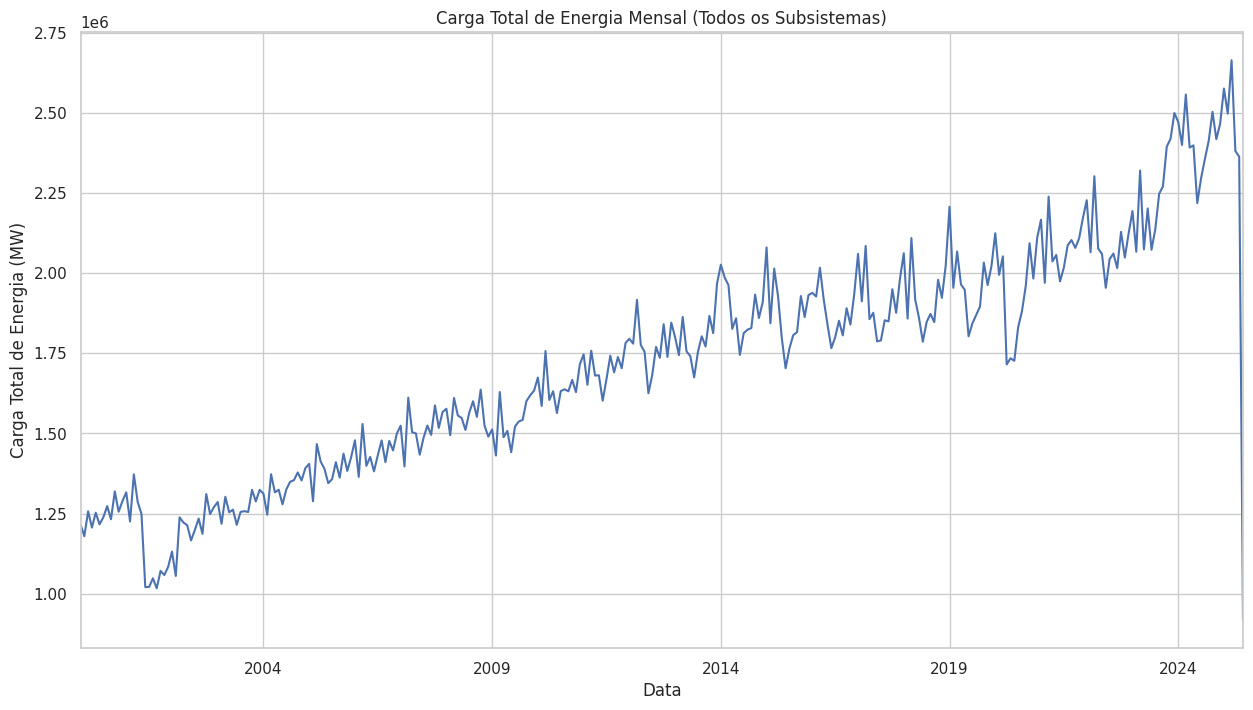

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

# Defina o período desejado: 'D' (Diário), 'W' (Semanal), 'ME' (Mensal)
periodo = 'ME'

# Reamostra os dados por mês ('ME')
df_semanal = df['val_cargaenergiamwmed'].resample(periodo).sum()

df_semanal.plot(title='Carga Total de Energia Mensal (Todos os Subsistemas)')
plt.ylabel('Carga Total de Energia (MW)')
plt.xlabel('Data')
plt.show()

### Gráfico 2: Carga de Energia Diária por Subsistema
Mostra quais subsistemas consomem mais energia e como o consumo deles evoluiu.

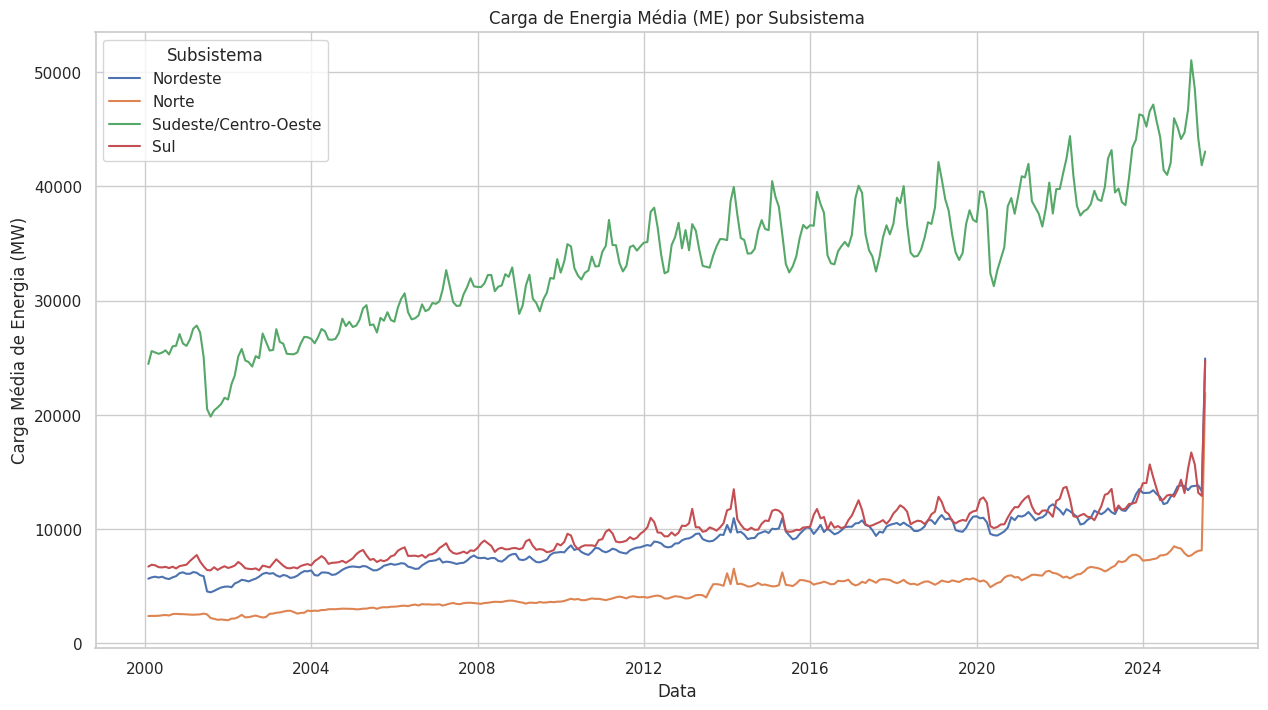

In [ ]:
# Defina o período desejado: 'D' (Diário), 'W' (Semanal), 'ME' (Mensal)
# periodo = 'ME' # Definido anteriormente, pode ser mudado localmente

df_plot = df.groupby('nom_subsistema')['val_cargaenergiamwmed'].resample(periodo).mean().reset_index()

plt.figure()
sns.lineplot(data=df_plot, x=df_plot.columns[1], y='val_cargaenergiamwmed', hue='nom_subsistema')
plt.title(f'Carga de Energia Média ({periodo}) por Subsistema')
plt.ylabel('Carga Média de Energia (MW)')
plt.xlabel('Data')
plt.legend(title='Subsistema')
plt.show()

### Gráfico 3: Distribuição da Carga de Energia por Subsistema
Um boxplot para comparar a distribuição estatística (mediana, quartis, outliers) da carga de energia entre os diferentes subsistemas.

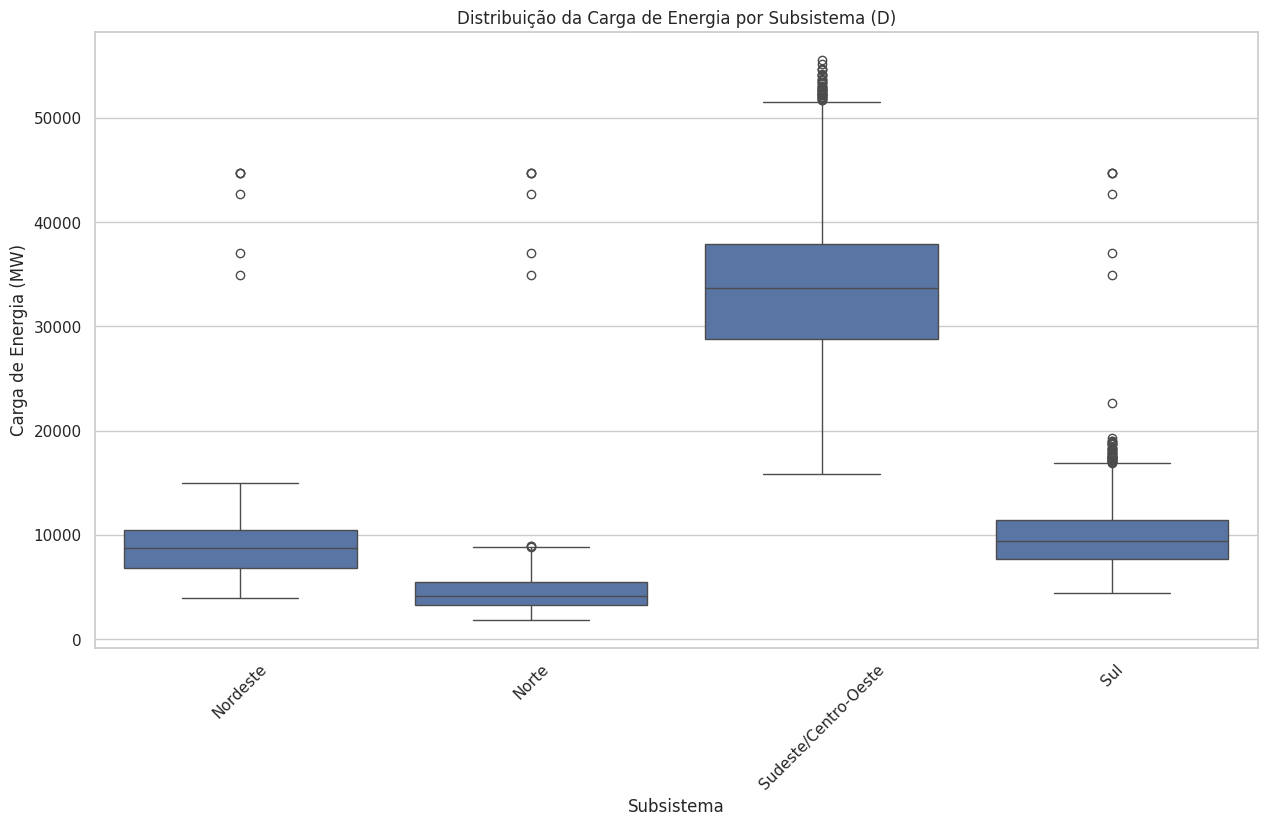

In [ ]:
# Escolha o período: 'D' (dia), 'W' (semana), 'ME' (mês)
periodo = 'ME' # Definido anteriormente, pode ser mudado localmente

df_box = df.groupby([coluna_subsistema, pd.Grouper(freq=periodo)])[coluna_valor].mean().reset_index()

plt.figure()
sns.boxplot(data=df_box, x=coluna_subsistema, y=coluna_valor)
plt.title(f'Distribuição da Carga de Energia por Subsistema ({periodo})')
plt.ylabel('Carga de Energia (MW)')
plt.xlabel('Subsistema')
plt.xticks(rotation=45)
plt.show()

### Gráfico 4: Análise Sazonal - Carga Média por Mês
Este gráfico revela padrões sazonais anuais, mostrando a carga média para cada mês do ano.

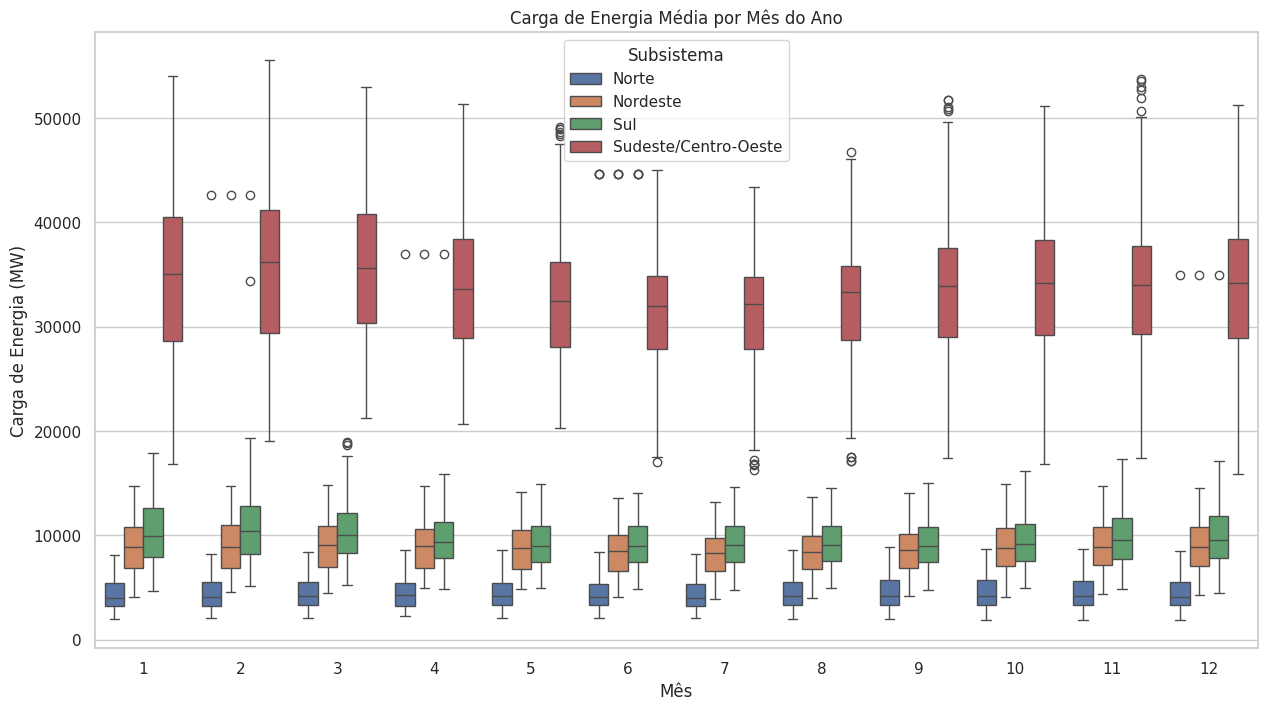

In [ ]:
df['mes'] = df.index.month
plt.figure()
sns.boxplot(data=df, x='mes', y='val_cargaenergiamwmed', hue='nom_subsistema')
plt.title('Carga de Energia Média por Mês do Ano')
plt.ylabel('Carga de Energia (MW)')
plt.xlabel('Mês')
plt.legend(title='Subsistema')
plt.show()

### Gráfico 5: Análise Sazonal - Carga Média por Dia da Semana
Mostra o padrão de consumo de energia típico dentro de uma semana. Aparentemente, não é muito significante.

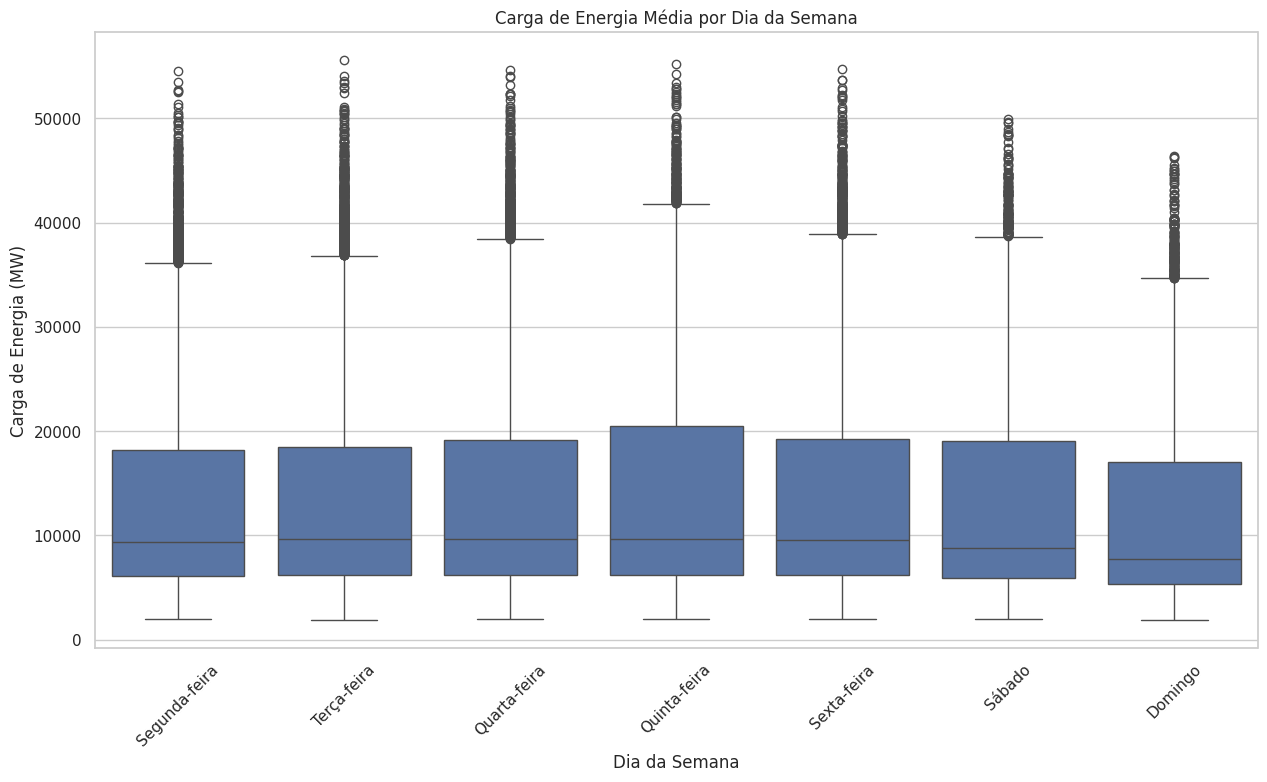

In [ ]:
df['dia_da_semana'] = df.index.day_name()
ordem_dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ordem_dias_pt = ["Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira", "Sábado", "Domingo"]

df['dia_da_semana'] = pd.Categorical(df['dia_da_semana'], categories=ordem_dias, ordered=True)
df_plot = df.copy()
df_plot['dia_da_semana'] = df_plot['dia_da_semana'].cat.rename_categories(ordem_dias_pt)

plt.figure()
sns.boxplot(data=df_plot, x='dia_da_semana', y='val_cargaenergiamwmed')
plt.title('Carga de Energia Média por Dia da Semana')
plt.ylabel('Carga de Energia (MW)')
plt.xlabel('Dia da Semana')
plt.xticks(rotation=45)
plt.show()

### Gráfico 6: Distribuição Geral dos Valores de Carga
Este histograma mostra a forma da distribuição dos dados, respondendo a perguntas como "Quais são os valores de carga mais comuns?".

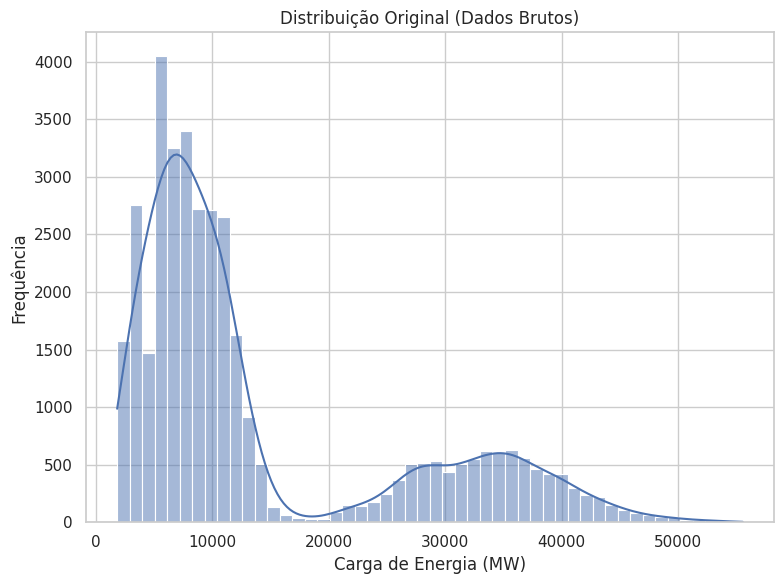

In [ ]:
# Escolha o período: 'D' (dia), 'W' (semana), 'ME' (mês)
periodo = 'D' # Definido anteriormente, pode ser mudado localmente

dados_originais = df[coluna_valor]
dados_resampled = df[coluna_valor].resample(periodo).mean()

fig, ax = plt.subplots(1, 1, figsize=(8, 6)) # 1 linha, 1 coluna
sns.set_theme(style="whitegrid")


# --- Opção A: Mostrar a Distribuição Original ---
sns.histplot(dados_originais, kde=True, bins=50, ax=ax)
ax.set_title('Distribuição Original (Dados Brutos)')
ax.set_xlabel('Carga de Energia (MW)')
ax.set_ylabel('Frequência')


# --- Opção B: Mostrar a Distribuição Reamostrada ---
# sns.histplot(dados_resampled, kde=True, bins=20, ax=ax)
# ax.set_title(f"Distribuição Agrupada por Período ('{periodo}')")
# ax.set_xlabel(f'Carga Média por Período ({periodo}) (MW)')
# ax.set_ylabel('Frequência')


plt.tight_layout()
plt.show()

### Gráfico 7: Decomposição da Série Temporal da Carga Total
A decomposição nos permite separar a série temporal em três componentes: a tendência de longo prazo (o crescimento ou declínio geral), a sazonalidade (padrões repetitivos anuais/semanais) e os resíduos (ruído ou anomalias). Isso nos ajuda a entender as diferentes forças que influenciam a carga de energia.

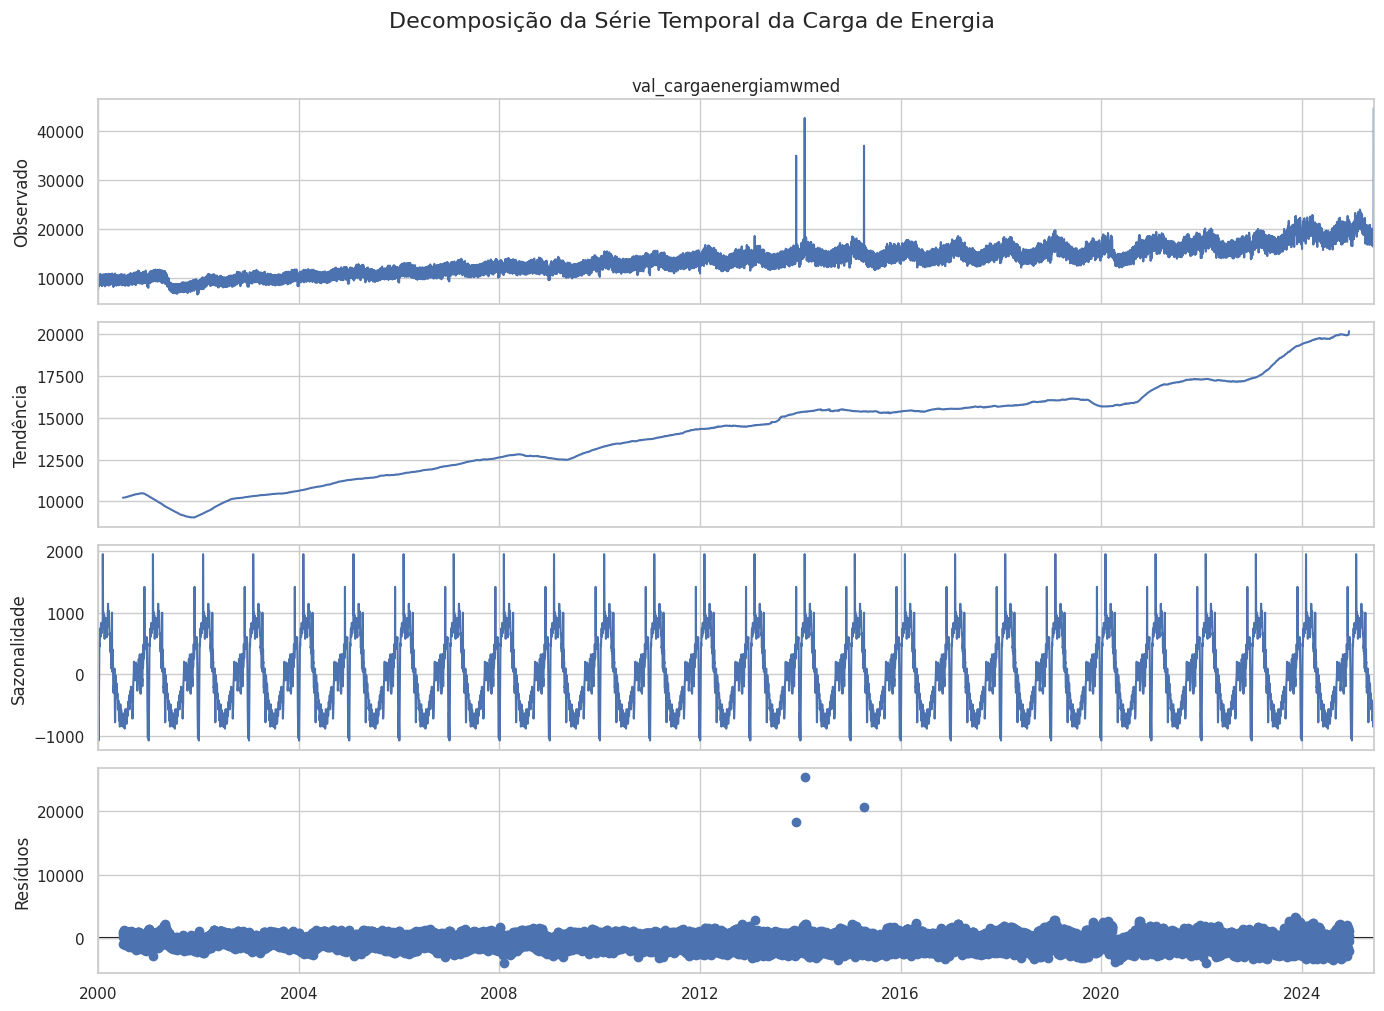

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Escolha o período: 'D' (dia), 'W' (semana) FIXME: 'ME não está funcionando
periodo = 'D'  # Definido anteriormente, pode ser mudado localmente

df_diario = df['val_cargaenergiamwmed'].resample(periodo).mean().dropna()

decomposicao = seasonal_decompose(df_diario, model='additive', period=365)

fig = decomposicao.plot()
fig.set_size_inches(14, 10)

fig.suptitle('Decomposição da Série Temporal da Carga de Energia', fontsize=16, y=1.01)
plt.gcf().get_axes()[0].set_ylabel('Observado')
plt.gcf().get_axes()[1].set_ylabel('Tendência')
plt.gcf().get_axes()[2].set_ylabel('Sazonalidade')
plt.gcf().get_axes()[3].set_ylabel('Resíduos')

plt.tight_layout()
plt.show()

### Gráfico 8: Carga por Subsistema com Média Móvel

Este gráfico melhora a visualização da série temporal por subsistema. Ao adicionar uma média móvel, suavizamos as flutuações diárias e tornamos as tendências de longo prazo e as anomalias mais fáceis de identificar para cada região.

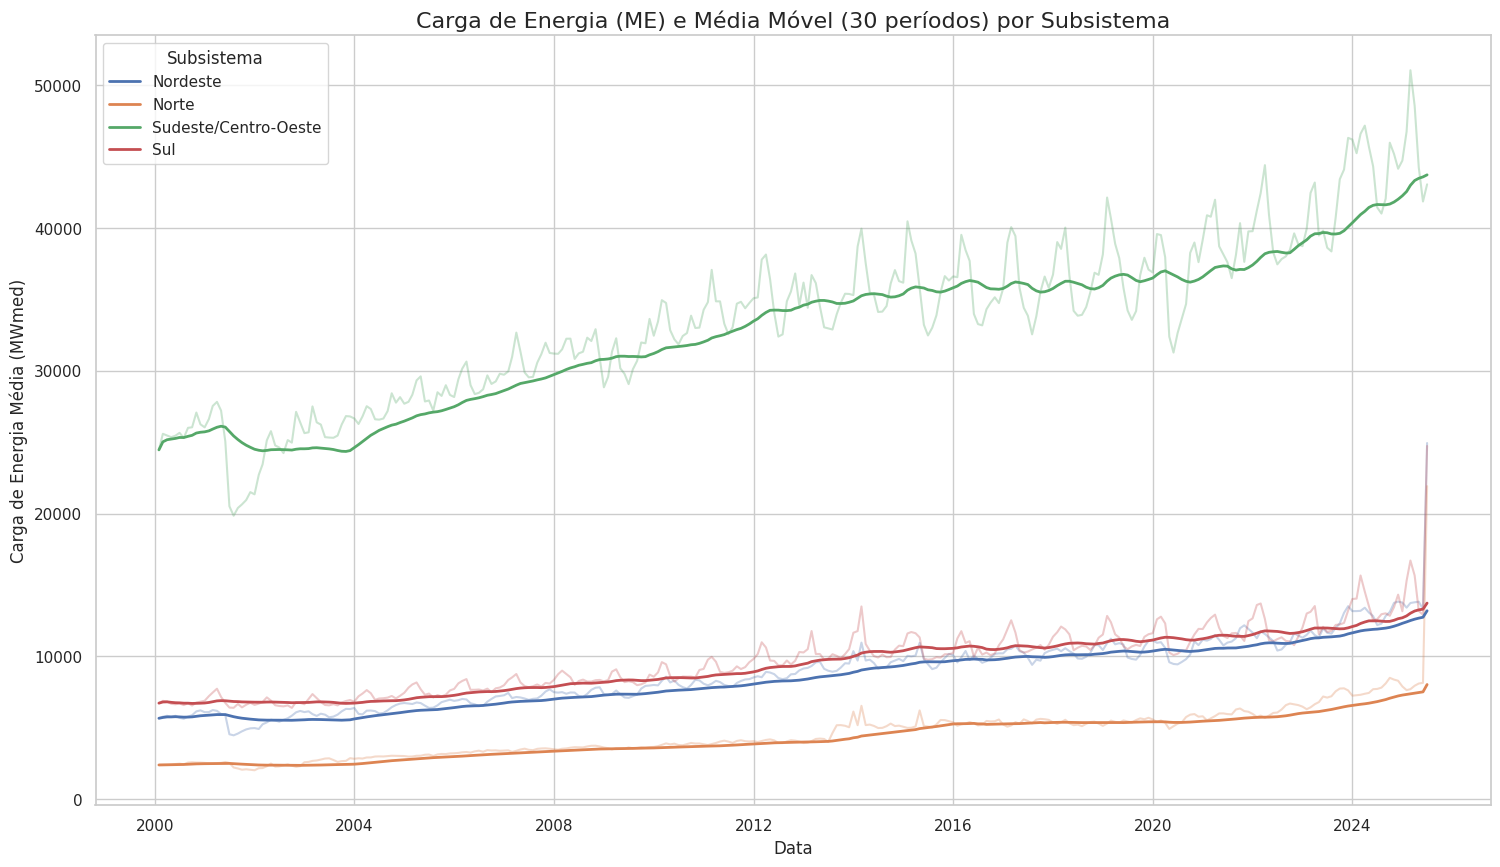

In [ ]:
# Escolha o período: 'D' (dia), 'W' (semana), 'ME' (mês)
periodo = 'ME'  # Definido anteriormente, pode ser mudado localmente

df_diario = df.groupby([pd.Grouper(freq=periodo), coluna_subsistema])[coluna_valor].mean().reset_index()

nome_coluna_data = df_diario.columns[0]
df_diario = df_diario.sort_values(by=[coluna_subsistema, nome_coluna_data])
df_diario['media_movel_30d'] = df_diario.groupby(coluna_subsistema)[coluna_valor] \
                                        .transform(lambda x: x.rolling(window=30, min_periods=1).mean())

plt.figure(figsize=(18, 10))

sns.lineplot(data=df_diario, x=nome_coluna_data, y=coluna_valor, hue=coluna_subsistema, alpha=0.3, legend=False)
sns.lineplot(data=df_diario, x=nome_coluna_data, y='media_movel_30d', hue=coluna_subsistema, linewidth=2)

plt.title(f'Carga de Energia ({periodo}) e Média Móvel (30 períodos) por Subsistema', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Carga de Energia Média (MWmed)', fontsize=12)
plt.legend(title='Subsistema')
plt.grid(True)
plt.show()